In [1]:
import comet_ml
from comet_ml.query import Parameter
import pandas as pd
import numpy as np
import datetime
from statistics import mean

In [2]:
comet_api = comet_ml.api.API()
fedavg_query = (Parameter('SERVER_OPT') == "SGD") & (Parameter('SERVER_OPT_MOMENTUM') == None)
fedavgm_query = Parameter('SERVER_OPT_MOMENTUM') != None
fedadam_query = Parameter('SERVER_OPT') == "Adam"
fedadagrad_query = Parameter('SERVER_OPT') == "Adagrad"

def get_exps(query):
    return comet_api.query('federated-learning', 'server-side-opt-long', query)

fedavg_exps = get_exps(fedavg_query)
fedavgm_exps = get_exps(fedavgm_query)
fedadam_exps = get_exps(fedadam_query)
fedadagrad_exps = get_exps(fedadagrad_query)

In [3]:
def get_df(exps):
    teas = [float(exp.get_metrics_summary('test_acc')['valueMax']) for exp in exps]
    ids = [exp.id for exp in exps]
    dt = [datetime.datetime.fromtimestamp(exp.get_metadata()['endTimeMillis']/1000.0) for exp in exps]
    tea_avgs = [avg_acc_last_100(exp) for exp in exps]
    return pd.DataFrame({'id': ids, 'test_acc': teas, 'test_acc avg last 100': tea_avgs, 'dt': dt})

def avg_acc_last_100(exp):
    dict_acc = exp.get_metrics('test_acc')
    value = [float(record['metricValue']) for record in dict_acc]
    return mean(value[-100:])

In [4]:
fedadam_df = get_df(fedadam_exps)
fedavg_df = get_df(fedavg_exps)
fedavgm_df = get_df(fedavgm_exps)
fedadagrad_df = get_df(fedadagrad_exps)

In [20]:
def group_by_date(df):
    on = 'test_acc avg last 100'
    sampled = df.resample('H', on='dt').max()[[on]].join(df[['id', on]].set_index(on), on=on, lsuffix='_caller', rsuffix='_other').fillna(method='ffill')
    for i in range(len(sampled)-1):
        if sampled.iloc[i][on] > sampled.iloc[i+1][on]:
            sampled.iloc[i+1] = sampled.iloc[i]
    return sampled

In [21]:
fedadam_df_gr = group_by_date(fedadam_df)
fedavg_df_gr = group_by_date(fedavg_df)
fedavgm_df_gr = group_by_date(fedavgm_df)
fedadagrad_df_gr = group_by_date(fedadagrad_df)

In [22]:
fedadam_df_gr['opt'] = 'Adam'
fedavg_df_gr['opt'] = 'Avg'
fedavgm_df_gr['opt'] = 'AvgM'
fedadagrad_df_gr['opt'] = 'Adagrad'

df = pd.concat([fedadam_df_gr, fedavg_df_gr, fedavgm_df_gr, fedadagrad_df_gr])

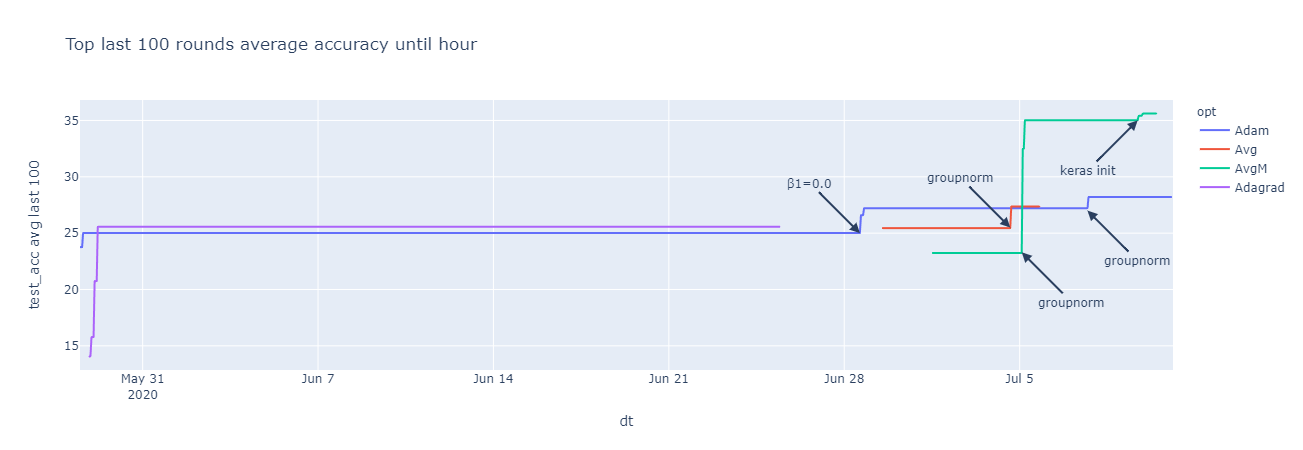

In [25]:
import plotly.express as px

# fig = px.line(df, y="test_acc", color='opt', title="Top last accuracy until day")
# fig.show()

fig = px.line(df, y="test_acc avg last 100", color='opt', title="Top last 100 rounds average accuracy until hour")#, hover_name='id')

adam_not = [("β1=0.0", datetime.datetime(year=2020, month=6, day=28, hour=15), 25, -50, -50),
            ("groupnorm",      datetime.datetime(year=2020, month=7, day=7, hour=17),  27,  50,  50)]

avg_not = [("groupnorm", datetime.datetime(year=2020, month=7, day=4, hour=15), 25.5, -50, -50)]

avgm_not = [("groupnorm",  datetime.datetime(year=2020, month=7, day=5, hour=2),  23.3, 50,  50),
            ("keras init", datetime.datetime(year=2020, month=7, day=9, hour=17), 35,   -50, 50)]

for t, d, acc, ax, ay in adam_not + avg_not + avgm_not:
    fig.add_annotation(
            x=d,
            y=acc,
            text=t,
            showarrow=True,
            arrowhead=2,
            arrowwidth=2,
            ax=ax,
            ay=ay,
            )
fig.show()